## Modelling time-dependent acquisition of positional information

### Modelling dynamics in an embryo

In this second notebook, we simulate a more realistic model of acquisition of time-dependent positional information. We show how to reproduce the results of Zhu _et al._ (2017) on Tribolium segmentation and generate corresponding kymographs (time-space maps of genetic expression). The network that we simulate encodes a "clock-like" behaviour with a cascade of genes expressed sequentially, before stabilizing in the anterior part of the embryo as the _caudal_ morphogen gradient disappears.

**Reference:**
<br>
Xin Zhu, Heike Rudolf, Lucas Healy, Paul François, Susan J Brown, Martin Klinger, and Ezzat El-Sherif. Speed reagulation of genetic cascades allows for evolvability in the body plan specification of insects. _Proceedings of the National Academy of Sciences of the United States of America_, 128(41):201702478-E8655, September 2017.

For this problem, we need to make the distinction between different cells seeing different dynamics of a morphogen (here, _caudal_). We model an embryo as a line of $200$ cells representing the tissue undergoing a patterning process. Each cell is an array with one variable corresponding to each protein in the network. We initialize all concentrations at $0$, except for the first gene,  _hb_, initialized at $0.2$.

**Note:**
<br>
For plotting purposes, we define the array  `ap_positions` consisting of the positions of the cells relative to the antero-posterior axis of the patterning tissue (normalized from 0 to 1). We find it more convenient to use the antero-posterior position of a cell rather than its index as the positional argument _x_ since it allows us to choose any number of cells to represent the whole segmenting tissue without affecting the resulting dynamics. This will be important later to define the position in corresponding functions. We also store the biochemical species' names (i.e. proteins) in the list  `species_names`, and assign a different color to each species in the list `species_colors`.

In [8]:
import numpy as np

n_cells = 200
ap_positions = np.linspace(0.0, 1.0, n_cells)

n_species = 5
species_names = ['hunchback', 'Kruppel', 'mille-pattes', 'giant', 'X']
species_colors = ['tab:blue', 'tab:red', 'tab:green', 'tab:orange', 'k:']

init_conc = np.zeros((n_cells, n_species))
init_conc[:,0] = 0.2

Similarly to the previous notebook, we define functions encoding the differential equations describing the interactions between proteins inside a single cell. Formally, the time derivative of the system can be written as

\begin{equation}
\frac{d \vec{P}}{dt} = 3 D(\vec{P}, M(t))+ S(\vec{P}, M(t))-\vec{P}
\end{equation}

where $\vec{P}$ is a vector of protein concentrations corresponding to the _hb_, _Kr_, _mlpt_, _gt_  and a "terminator" gene X repressing all other genes.

For this problem the derivative function is made of two parts: a dynamic network of interactions is encoded in $D(\vec{P}, M(t))$, and produces sequential gene activation. A  static network  of interactions $S(\vec{P}, M(t))$  amplifies and stabilizes an initial bias in the expression of one of the genes, while also attenuating the expression of the other genes. The static network is multistable, defining different stable cellular fates for $M(t)=0$.
Intuitively, the static and dynamic networks correspond to two families of transcriptional enhancers. The morphogen $M(t)$ controls the relative weight of each enhancer, so that the dynamics of the morphogen encodes the future fate. 

The functions require three input arguments. The first is the vector of concentrations (one component for each species), and the second the morphogen concentration. Notice here that we define the dynamics for one cell: the spatial difference only enters the equations through the morphogen dynamics that will be included below.
We also include the possibility to model RNAi experiments by using a vector named `rna_i`.

**Note:**
<br>
The length of the  `rna_i` vector needs to be equal to the number of species. Each of its elements must be equal to either 0 (meaning that we model this species' RNAi knockdown) or 1 (else).

In [9]:
# Dynamic part of the derivative
def dynamic(conc_vec, morphogen, rna_i):

    c = morphogen/(1.0+morphogen)
    hb = conc_vec[0]
    kr = conc_vec[1]
    mlpt = conc_vec[2]
    gt = conc_vec[3]
    x = conc_vec[4]

    d_hb = rna_i[0]*c*(hb/0.2)**5/(1.0 +(hb/0.2)**5)/(1.0 +(kr/0.12)**5)
    d_kr = rna_i[1]*c*(hb/0.4)**5/(1.0 +(hb/0.4)**5)/(1.0 +(mlpt/0.25)**5)/(1.0 +(gt/0.01)**5)
    d_mlpt = rna_i[2]*c*(kr/0.4)**5/(1.0 +(kr/0.4)**5)/(1.0 +(gt/0.3)**5)
    d_gt = rna_i[3]*c*(mlpt/0.4)**5/(1.0 +(mlpt/0.4)**5)/(1.0 +(x/0.08)**5)
    d_x = rna_i[4]*c*(gt/0.4)**5/(1.0 +(gt/0.4)**5)

    return np.array([d_hb, d_kr, d_mlpt, d_gt, d_x])


# Static part of the derivative
def static(conc_vec, morphogen, rna_i):

    c = 1.0/(1.0+morphogen)
    hb = conc_vec[0]
    kr = conc_vec[1]
    mlpt = conc_vec[2]
    gt = conc_vec[3]
    x = conc_vec[4]

    d_hb = rna_i[0]*c*(hb/0.4)**5/(1.0 +(hb/0.4)**5)/(1.0 +(kr/0.4)**5)
    d_kr = rna_i[1]*c*(kr/0.4)**5/(1.0 +(kr/0.4)**5)/(1.0 +(hb/0.4)**5)
    d_mlpt = rna_i[2]*c*(mlpt/0.4)**5/(1.0 +(mlpt/0.4)**5)
    d_gt = rna_i[3]*c*(gt/0.4)**5/(1.0 +(gt/0.4)**5)
    d_x = rna_i[4]*c*(x/0.4)**5/(1.0 +(x/0.4)**5)

    return np.array([d_hb, d_kr, d_mlpt, d_gt, d_x])


# Derivative function joining the two components
def derivative_single_cell(conc_vec, morphogen, rna_i):
    
    return 3.0*dynamic(conc_vec, morphogen, rna_i) +static(conc_vec, morphogen, rna_i) -conc_vec

Again similarly to the previous notebook, we need to define the dynamics of a morphogen, and this time we need to take into account the spatial dependency of the morphogen, which is one extra parameter of the corresponding function . We model the dynamics of the morphogen as follows: the gradient remains static for a given amount of time (`time_static_morphogen`) before it starts to retract spatially (via a linear increase of `flat_start`) while also becoming steeper (via an exponential increase of the exponent `n`).

**Notes:**
- To model a static morphogen gradient, we would simply need to set the time during which the morphogen gradient remains static, `time_static_morphogen`, to a value that is greater than the total simulation time.
- Applying a condition to an array of a given size returns an array of the same size containing Boolean variables indicating whether or not the associated element of the original array satisifes the condition. We use this  `numpy` functionality here to set the morphogen concentration to 0 in a specific region of the tissue.

In [10]:
def compute_morphogen(x, t, morphogen_parameters):
    
    peak = morphogen_parameters["peak"]
    shift = morphogen_parameters["shift"]
    time_static_morphogen = morphogen_parameters["time_static_morphogen"]
    retracting_speed = morphogen_parameters["retracting_speed"]

    if (t < time_static_morphogen):
        
        flat_start = morphogen_parameters["flat_start"]
        n = morphogen_parameters["n"]
        
    else:
        
        flat_start = morphogen_parameters["flat_start"]+retracting_speed*(t-time_static_morphogen)
        n = morphogen_parameters["n"]*np.exp(t-time_static_morphogen)
        if (n > 100.0):    n = 100.0
        
    morphogen = peak*((x-shift)/flat_start)**n/(1.0 +((x-shift)/flat_start)**n)
    morphogen[(x-shift) < 0.0] = 0.0
    
    return morphogen

We now define the function to integrate the dynamics over the entire embryo. So far we have defined a function that computes the derivative of a single cell that takes an array of 5 elements (the 5 different proteins) as an argument. However the global derivative function must process a vector of size `n_cells` $\times$ `n_species`, corresponding to the `n_species`$=5$ protein concentrations in each cell of the modelled embryo. The role of the global derivative function is to split the global concentration vector into `n_cells` smaller vectors that correspond to the individual cells and can be passed to `derivative_single_cell`.

Furthermore, two objects are considered as parameters of the global derivative function: the vector for the morphogen profile across the whole tissue and the `rna_i` vector for RNAi simulations.

**Note:**
<br>
This derivative is the function that will be passed in the argument of the `ode` function (from the `scipy` package) that will allow us to perform the integration to find the time course of the dynamics. `ode` accepts only functions that follow certain rules:

```python
def derivatives(t, concentrations, param1, param2, ...):
    ...
    return derivative_vec   # Same size as concentrations
```

For the  `ode` function to work correctly, the first argument of the function that we wish to integrate needs to be time, and the second argument needs to be a 1D array. The following arguments are optional and are seen as parameters. They need to be passed to  `ode` using the  `set_f_params` function.


In [11]:
def derivative_whole_tissue(t, conc_vec, morphogen_parameters, rna_i):

    conc_vec = conc_vec.reshape(n_cells, n_species).transpose()
    morphogen = compute_morphogen(ap_positions, t, morphogen_parameters)
    
    return derivative_single_cell(conc_vec, morphogen, rna_i).transpose().reshape(n_cells*n_species)

We now define a function taking various arguments and performing the actual numerical integration.  The first argument is the matrix of initial concentrations of every species in every cell. The second argument is a dictionary specifying the initial time, the total duration and the time step of integration. The third argument is another dictionary specifying the different parameters required for modelling the morphogen gradient at each time point. The last argument is the array specifying if we perform RNAi experiments on one of the genes if needed.

The function first sets the integration options, and then performs the integration, using the `scipy.integrate` numerical  `ode` integrator. It returns three outputs. The first output is a `numpy` array consisting of the results of the simulation: for every cell, we have a matrix for which each line represents the temporal evolution of the concentration of one protein inside that specific cell. The second output is the morphogen gradient across the tissue at each time point. The third output is the array of times used for the integration.

**Note:**
<br>
When dealing with stiff equations for which the time-scale of the dynamics can vary greatly, it is better to use a stiff integrator like `lsoda`. Other (non-stiff) integrators include  `dopri5`, which is based on the Runge-Kunta method. As mentioned in the previous note, the  `ode` function requires the second argument of the function that we wish to integrate to be a single array. Therefore, we need to reshape the array for the initial concentrations `init_conc` accordingly. We also test if the integration was successful at each time step before keeping the results. If the integration was not successful, we stop the integration and print an error message. Finally, if needed, the current species concentrations and the current time can be accessed via  `integrator.y` and  `integrator.t` respectively.

In [12]:
from scipy.integrate import ode

def integration(init_conc, integration_time, morphogen_parameters, rna_i):
 
    # Set the integration options
    integrator = ode(derivative_whole_tissue)
    integrator.set_integrator('lsoda', with_jacobian=False, rtol=1e-5, nsteps=1000)
    integrator.set_f_params(morphogen_parameters, rna_i)

    total_time = integration_time["total_time"]
    time_step = integration_time["time_step"]
    init_time = integration_time["init_time"]
    times = np.arange(init_time, init_time+total_time, time_step)

    init_conc = init_conc.reshape(n_cells*n_species)
    integrator.set_initial_value(init_conc, init_time)
   
    results = [init_conc]
    morphogen_gradient = [compute_morphogen(ap_positions, init_time, morphogen_parameters)]
    
    
    # Perform the integration
    for t in times[1:]:

        integrator.integrate(t)
   
        if (integrator.successful):
        
            results.append(integrator.y)
            morphogen_gradient.append(compute_morphogen(ap_positions, integrator.t, morphogen_parameters))
            
        else:
            print("An error occurred during the integration.")
            break
           
    
    # Output the results
    results = np.array(results).transpose()
    results = results.reshape(n_cells, n_species, len(results[0]))
    morphogen_gradient = np.array(morphogen_gradient).transpose()
    
    return results, morphogen_gradient, times

Now that we have defined all integration tools, we build some routine allowing to visualize the spatiotemporal dynamics of the system. Very simply, the spatiotemporal dynamics of each gene can be encoded into a matrix, where one dimension corresponds to time and the other to space. A kymograph is a visualization of such a matrix. We can rescale the concentrations of each protein between $0$ and $1$ and define a color map continuously associating colors to concentrations, which defines the kymograph.

**Note:**
<br>
In the `imshow` function, we specify the interpolation scheme to get a smoother image. We also set the aspect to `auto`, which can improve the visual aspect of the kymograph, especially when we have a lot more time points than positions, or vice versa. We normalize the color scheme for the heatmaps to the same minimal and maximal values (`vmin` and `vmax`) for the 5 different species to allow better comparison. However, this means that we are not able to visualize variations in concentrations higher than `vmax`.

In [13]:
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline

def plot_kymographs(results, morphogen_gradient):
    
    fig, ax = plt.subplots(3,2)
    
    # Plot kymographs for the different species
    for species_index in range(n_species):
        
        i = int((species_index)/2)  # Row index in the plot grid
        j = species_index%2  # Column index in the plot grid
        
        ax[i,j].axis('off')

        normal = colors.Normalize(vmin=0.0, vmax=1.0)   
        graph = ax[i,j].imshow(results[:,species_index,:], norm=normal, origin='lower', interpolation='bilinear', aspect='auto')
    
        colorbar = fig.colorbar(graph, ticks=[1.0,0.5,0.0], ax=ax[i,j])
        colorbar.ax.tick_params(labelsize=8)
        ax[i,j].set_title(species_names[species_index], fontsize=10)
    
    
    # Plot a kymograph for the morphogen gradient
    ax[2,1].axis('off')

    normal = colors.Normalize(vmin=0.0, vmax=1.0)
    graph = ax[2,1].imshow(morphogen_gradient, norm=normal, origin='lower', interpolation='bilinear', aspect='auto')

    colorbar = fig.colorbar(graph, ticks=[1.0,0.5,0.0], ax=ax[2,1])
    colorbar.ax.tick_params(labelsize=8)
    ax[2,1].set_title('caudal', fontsize=10)
    
    fig.savefig('Kymographs.png', dpi=300)

Rather than plotting the kymograph, we can also represent the concentration of a given species across the whole segmenting tissue for all time points as a 3D surface. The following function plots and saves such a graph for the species with index specified by the argument `species_index` (here, from 1 to 5, and not from 0 to 4). We can  also define a function that plots and saves the final concentration profile across the whole tissue, and a function that plots and saves the time evolution of the system in a given cell. 

In [14]:
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_surface(species_index, results, times):

    fig, ax = plt.subplots(subplot_kw={"projection":"3d"})
    
    x, t = np.meshgrid(ap_positions, times)
    ax.plot_surface(x, t, results[:,species_index-1,:].transpose(), color=species_colors[species_index-1])

    ax.set_title(species_names[species_index-1])
    ax.set_xlabel("AP position")
    ax.set_ylabel("Time")
    ax.set_zlabel("Concentration")
    
    fig.savefig('Conc_3d_surface.png', dpi=300)


def plot_final_conc_profile(results, morphogen_gradient):

    fig, ax = plt.subplots()
    
    ax.plot(ap_positions, morphogen_gradient[:,-1], color='tab:gray', label='caudal')
    for species_index in range(n_species):
        ax.plot(ap_positions, results[:,species_index,-1], species_colors[species_index], label=species_names[species_index])

    ax.set_xlabel('AP position')
    ax.set_ylabel('Concentration')
    ax.legend()

    fig.savefig('Final_conc.png', dpi=300)
    
    
def plot_time_course(cell_position, results, morphogen_gradient, times):

    fig, ax = plt.subplots()
    
    ax.plot(times, morphogen_gradient[cell_position,:], color='tab:gray', label='caudal')
    for species_index in range(n_species):
        ax.plot(times, results[cell_position,species_index,:], species_colors[species_index], label=species_names[species_index])

    ax.set_xlabel('Time')
    ax.set_ylabel('Concentration in the cell at '+str(int(100*ap_positions[cell_position]))+'% of the tissue')
    ax.legend()

    fig.savefig('Conc_time_course.png', dpi=300)

Lastly, we are ready to simulate and plot the desired behaviour. The following lines initialize the simulations and use all previously defined functions to visualize results.

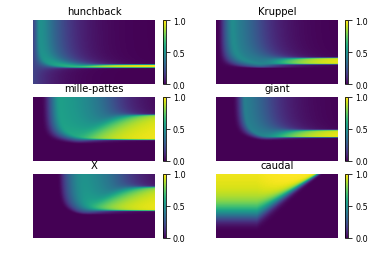

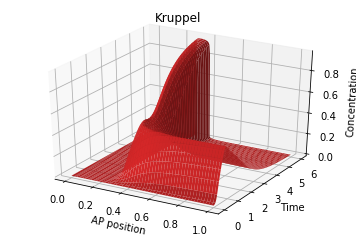

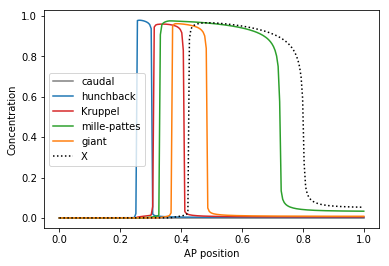

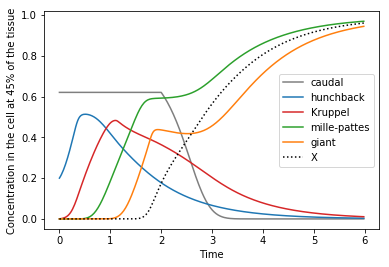

In [15]:
# Specify the value of all required parameters
 
integration_time = {
    "total_time" : 6.0,
    "time_step" : 0.02,
    "init_time" : 0.0
}

morphogen_parameters = {
    "peak" : 1.0,
    "shift" : 0.0,
    "flat_start" : 0.4,
    "n" : 4.0,
    "time_static_morphogen" : 2.0,
    "retracting_speed" : 0.2
}

rna_i = np.ones(n_species)


# Perform the integration

results, morphogen_gradient, times = integration(init_conc, integration_time, morphogen_parameters, rna_i)


# Generate the desired figures

plot_kymographs(results, morphogen_gradient)

species_index = 2
plot_3d_surface(species_index, results, times)

plot_final_conc_profile(results, morphogen_gradient)

cell_position = int(0.45*n_cells)
plot_time_course(cell_position, results, morphogen_gradient, times)

To model RNAi experiments, we run the simulations by putting to $0$ the gene that we wish to remove. For instance, the following lines simulate and show the behaviour of the embryo for _gt_  RNAi. 

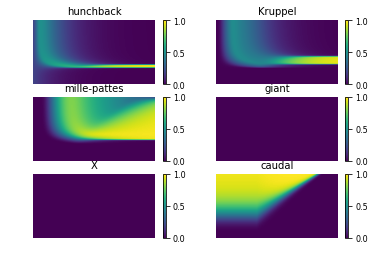

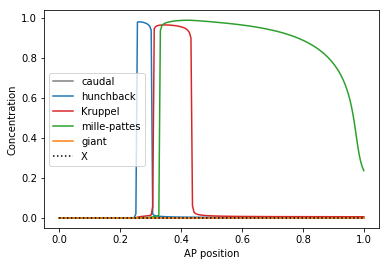

In [16]:
rna_i = np.array([1,1,1,0,1])

results, morphogen_gradient, times = integration(init_conc, integration_time, morphogen_parameters, rna_i)

plot_kymographs(results, morphogen_gradient)
plot_final_conc_profile(results, morphogen_gradient)

We can also model the _pan_ RNAi experiments by changing the dynamics of the morphogen.

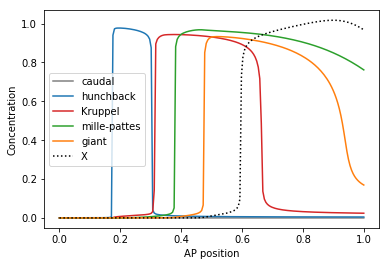

In [17]:
rna_i = np.array([1,1,1,1,1])

morphogen_parameters["peak"] = 0.5
morphogen_parameters["shift"] = -0.2/3.0
morphogen_parameters["n"] = 2.0

results, morphogen_gradient, times = integration(init_conc, integration_time, morphogen_parameters, rna_i)

plot_final_conc_profile(results, morphogen_gradient)